In [14]:
import pickle
import os
import glob
import matplotlib.pyplot as plt
import pandas as pd

In [64]:
group_id = "exp_test"

# load result
result_files = glob.glob(f"./results/{group_id}/*.pickle")
results = []
for file in result_files:
    with open(file, "rb") as f:
        results.append(pickle.load(f))

# create plots folder
os.makedirs(f"./plots/{group_id}/", exist_ok=True)

In [65]:
# make results into dataframe
df_columns = ["model", "label", "accuracy", "precision", "TP", "TN", "FP", "FN", "n_samples", "n_trials", "model", "time_elapsed", "ex_id"]
df_data = []
for r in results:
    args = r["args"]
    n_trials = args.n_trials
    max_retry = args.max_retry
    model = args.model
    time_elapsed = r["finish_time"] - r["start_time"]
    ex_id = r["experiment_id"]
    for trial in r["result"]:
        for sample in trial:
            df_data.append([
                model,
                sample["class label"],
                sample["accuracy"],
                sample["precision"],
                sample["TP"],
                sample["TN"],
                sample["FP"],
                sample["FN"],
                sample["n_samples"],
                n_trials,
                model,
                time_elapsed,
                ex_id
            ])
df_results = pd.DataFrame(df_data, columns=df_columns)
df_results

,model,label,accuracy,precision,TP,TN,FP,FN,n_samples,n_trials,model
0,gpt-3.5-turbo,Company,0.80,0.60,3,5,2,0,5,10,gpt-3.5-turbo
1,gpt-3.5-turbo,EducationalInstitution,0.90,0.80,4,5,1,0,5,10,gpt-3.5-turbo
2,gpt-3.5-turbo,Artist,0.70,0.40,2,5,3,0,5,10,gpt-3.5-turbo
3,gpt-3.5-turbo,Athlete,0.50,0.00,0,5,5,0,5,10,gpt-3.5-turbo
4,gpt-3.5-turbo,OfficeHolder,0.80,0.60,3,5,2,0,5,10,gpt-3.5-turbo
...,...,...,...,...,...,...,...,...,...,...,...
695,gpt-3.5-turbo,Animal,1.00,1.00,25,25,0,0,25,10,gpt-3.5-turbo
696,gpt-3.5-turbo,Plant,0.78,0.56,14,25,11,0,25,10,gpt-3.5-turbo
697,gpt-3.5-turbo,Album,0.78,0.56,14,25,11,0,25,10,gpt-3.5-turbo
698,gpt-3.5-turbo,Film,0.94,0.88,22,25,3,0,25,10,gpt-3.5-turbo


In [66]:
# group by n_sample
res_g_sample = df_results.groupby(by=["label","n_samples"], as_index=False).mean("precision", "accuracy")
res_g_sample

,label,n_samples,accuracy,precision,TP,TN,FP,FN,n_trials
0,Album,5,0.890000,0.780000,3.9,5.0,1.1,0.0,10.0
1,Album,10,0.820000,0.640000,6.4,10.0,3.6,0.0,10.0
2,Album,15,0.800000,0.600000,9.0,15.0,6.0,0.0,10.0
3,Album,20,0.792500,0.585000,11.7,20.0,8.3,0.0,10.0
4,Album,25,0.766000,0.532000,13.3,25.0,11.7,0.0,10.0
...,...,...,...,...,...,...,...,...,...
65,WrittenWork,5,0.990000,0.980000,4.9,5.0,0.1,0.0,10.0
66,WrittenWork,10,0.960000,0.920000,9.2,10.0,0.8,0.0,10.0
67,WrittenWork,15,0.873333,0.746667,11.2,15.0,3.8,0.0,10.0
68,WrittenWork,20,0.872500,0.745000,14.9,20.0,5.1,0.0,10.0


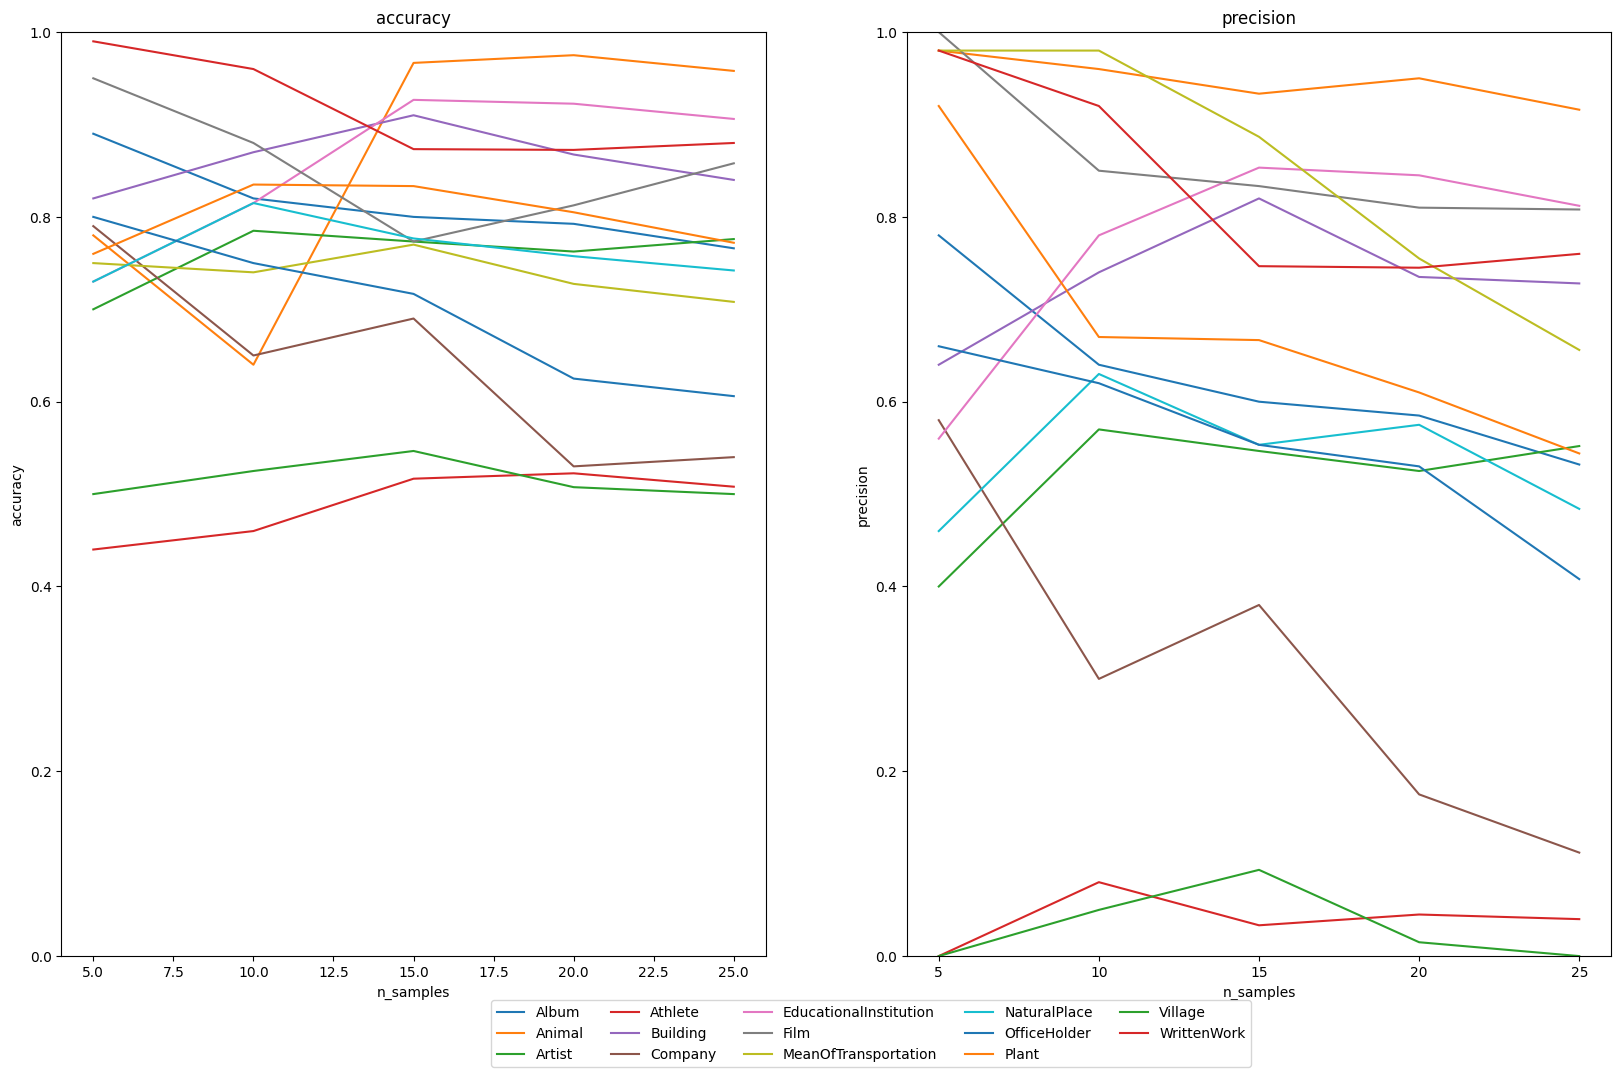

In [113]:
# plot accuracy and precision with df_results
# x axis: label
# y axis: accuracy/precision (average of all trials)
# group by n_sample

# plot
plt.figure(figsize=(20, 12))
# plt.title(f"{model} - dbpedia_14 dataset - {group_id}")
# plt.xlabel("n_samples")
# plt.ylim(0, 1)

sub_acc = plt.subplot(1, 2, 1)
sub_acc.set_title("accuracy")
sub_acc.set_xlabel("n_samples")
sub_acc.set_ylabel("accuracy")
sub_acc.set_ylim(0, 1)

sub_prec = plt.subplot(1, 2, 2)
sub_prec.set_title("precision")
sub_prec.set_xlabel("n_samples")
sub_prec.set_ylabel("precision")
sub_prec.set_ylim(0, 1)

labels = []
experiment_id = ""
# get average of accuracy and precision for each label group by n_sample
for l, klass in res_g_sample.groupby(by="label"):
    experiment_id = klass["ex_id"].iloc[0]
    precs_by_n_sample = []
    accs_by_n_sample = []
    n_list = []
    for n_sample, data in klass.groupby(by="n_samples"):
        n_list.append(n_sample)
        precs_by_n_sample.append(data["precision"].mean())
        accs_by_n_sample.append(data["accuracy"].mean())
    sub_prec.plot(n_list, precs_by_n_sample, label=l)
    sub_acc.plot(n_list, accs_by_n_sample, label=l)
    plt.xticks(n_list)
    labels.append(l)
plt.legend(labels, loc="upper left", bbox_to_anchor=(-0.6, -0.04), ncol=5) 

# save images
plt.savefig(f"./plots/{group_id}/dbpedia_14_{experiment_id}.png")
